In [1]:
import random
import numpy as np
import sklearn.svm as svm
from sklearn.datasets import make_classification


class TSVM(object):
    '''
    半监督SVM
    '''
    def __init__(self, kernel='linear'):
        self.Cl, self.Cu = 1.5, 0.001
        self.kernel = kernel
        self.clf = svm.SVC(C=1.5, kernel=self.kernel)

    def train(self, X1, Y1, X2):
        N = len(X1) + len(X2)
        # 样本权值初始化
        sample_weight = np.ones(N)
        sample_weight[len(X1):] = self.Cu

        # 用已标注部分训练出一个初始SVM
        self.clf.fit(X1, Y1)
        
        # 对未标记样本进行标记
        Y2 = self.clf.predict(X2)
        Y2 = Y2.reshape(-1,1)
        
        X = np.vstack([X1, X2])
        Y = np.vstack([Y1, Y2])
        
        # 未标记样本的序号
        Y2_id = np.arange(len(X2))
        
        while self.Cu < self.Cl:
            # 重新训练SVM, 之后再寻找易出错样本不断调整
            self.clf.fit(X, Y, sample_weight=sample_weight)
            while True:
                Y2_decision = self.clf.decision_function(X2)   # 参数实例到决策超平面的距离
                Y2 = Y2.reshape(-1)
                epsilon = 1 - Y2 * Y2_decision
                negative_max_id = Y2_id[epsilon==min(epsilon)]
                # print(epsilon[negative_max_id][0])
                if epsilon[negative_max_id][0] > 0:
                    # 寻找很可能错误的未标记样本，改变它的标记成其他标记
                    pool = list(set(np.unique(Y1))-set(Y2[negative_max_id]))
                    Y2[negative_max_id] = random.choice(pool)
                    Y2 = Y2.reshape(-1, 1)
                    Y = np.vstack([Y1, Y2])
                    
                    self.clf.fit(X, Y, sample_weight=sample_weight)
                else:
                    break
            self.Cu = min(2*self.Cu, self.Cl)
            sample_weight[len(X1):] = self.Cu

    def score(self, X, Y):
        return self.clf.score(X, Y)

    def predict(self, X):
        return self.clf.predict(X)

if __name__ == '__main__':
    features, labels = make_classification(n_samples=200, n_features=3, 
                                           n_redundant=1, n_repeated=0, 
                                           n_informative=2, n_clusters_per_class=2)
    n_given = 70
    # 取前n_given个数字作为标注集
    X1 = np.copy(features)[:n_given]
    X2 = np.copy(features)[n_given:]
    Y1 = np.array(np.copy(labels)[:n_given]).reshape(-1,1)
    Y2_labeled = np.array(np.copy(labels)[n_given:]).reshape(-1,1)
    model = TSVM()
    model.train(X1, Y1, X2)
    accuracy = model.score(X2, Y2_labeled)
    print(accuracy)

0.9230769230769231


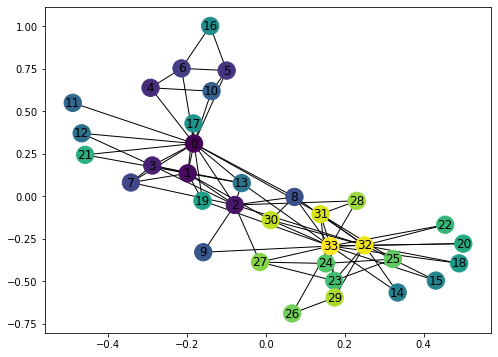

迭代次数 1
迭代次数 2
迭代次数 3
迭代次数 4
迭代次数 5
迭代次数 6
迭代次数 7
迭代次数 8
迭代次数 9
迭代次数 10
社区数量 2


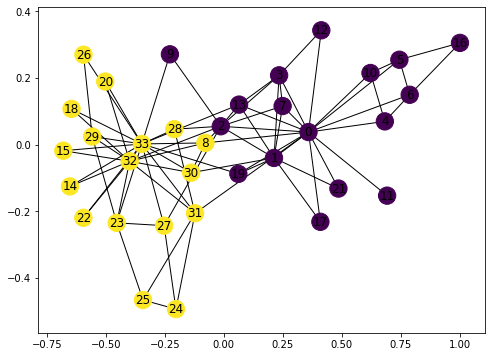

In [3]:
import random
import networkx as nx
import matplotlib.pyplot as plt

class LPA():
    '''
    标签传播算法：传播标签来划分社区
    算法终止条件：迭代次数超过设定值
    self.G：图
    return： None
    '''
    def __init__(self, G, iters=10):
        self.iters = iters
        self.G = G
        
    def train(self):
        max_iter_num = 0 # 迭代次数

        while max_iter_num < self.iters:
            max_iter_num += 1
            print('迭代次数',max_iter_num)

            for node in self.G:
                count = {} # 记录邻居节点及其标签
                for nbr in self.G.neighbors(node): # node的邻居节点
                    label = self.G.node[nbr]['labels'] 
                    count[label] = count.setdefault(label,0) + 1

                # 找到出现次数最多的标签
                count_items = sorted(count.items(),key=lambda x:-x[-1])
                best_labels = [k for k,v in count_items if v == count_items[0][1]]
                # 当多个标签频次相同时随机选取一个标签
                label = random.sample(best_labels,1)[0] 
                self.G.node[node]['labels'] = label # 更新标签

    def draw_picture(self):
        # 画图
        node_color = [float(self.G.node[v]['labels']) for v in self.G]
        pos = nx.spring_layout(self.G) # 节点的布局为spring型
        plt.figure(figsize = (8,6)) # 图片大小
        nx.draw_networkx(self.G,pos=pos,node_color=node_color)
        plt.show()

if __name__ == "__main__":
    G = nx.karate_club_graph() # 空手道
    # 给节点添加标签
    for node in G:
        G.add_node(node, labels = node) # 用labels的状态
    model = LPA(G)
    # 原始节点标签
    model.draw_picture()
    model.train()
    com = set([G.node[node]['labels'] for node in G])
    print('社区数量',len(com))
    # LPA节点标签
    model.draw_picture()